In [1]:
import copy
import glob

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import astropy.table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import AsymmetricPercentileInterval, ImageNormalize, LogStretch
from astropy.io import fits
from astropy.modeling.models import Gaussian1D
from astropy.modeling import fitting,models
from astropy.stats import gaussian_fwhm_to_sigma
import astropy.units as u

import sunpy.map
import sunpy.timeseries
import sunpy.sun.constants
from sunpy.coordinates import Helioprojective
from sunpy.map.maputils import all_coordinates_from_map, coordinate_is_on_solar_disk
from sunpy.coordinates import frames
from sunpy.net import Fido, attrs as a
from aiapy.calibrate import register, update_pointing,normalize_exposure
from pixel_to_world.my_pixel_to_world import my_pixel_to_world

import math
from math import pi,sqrt

import time

from scipy import optimize
from scipy.io import readsav

## Download

In [2]:
obs_start = "2011-01-27T22:58:56"
obs_end = "2011-01-27T22:59:00"
obs_time = a.Time(obs_start, obs_end)

unifresp = Fido.search(obs_time,a.Instrument.aia,a.Wavelength(304*u.angstrom)) 
unifresp

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size,Info
,,,,Angstrom,,,,,,,Mibyte,
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64,str57
2011-01-27 22:58:56.000,2011-01-27 22:58:57.000,SDO,AIA,304.0 .. 304.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]"


In [3]:
files = Fido.fetch(unifresp, path='data/{instrument}')

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1.fits:   0%|          | 0.00/9.97M [00:00<?, ?B/s]

## General introduction

In [76]:
AIA_filename="data/AIA/aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1.fits"
m_aia=sunpy.map.Map(AIA_filename)

SpatialPair(axis1=<Quantity 0.600165 arcsec / pix>, axis2=<Quantity 0.600165 arcsec / pix>)
[[ 0.99999737  0.00229364]
 [-0.00229364  0.99999737]]
SpatialPair(axis1=<Quantity 0.6 arcsec / pix>, axis2=<Quantity 0.6 arcsec / pix>)
[[1. 0.]
 [0. 1.]]


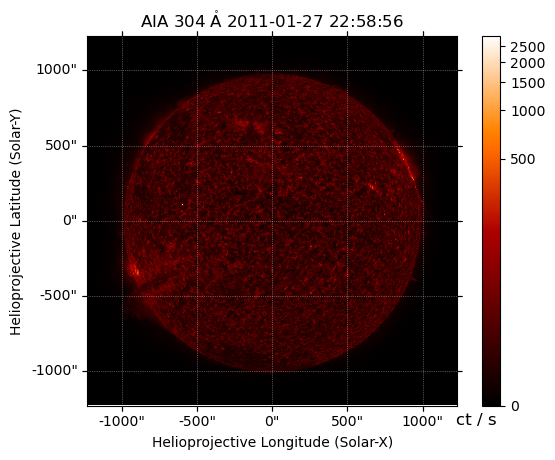

In [5]:
###########################################################
# The first step in this process is to update the metadata of the map to the
# most recent pointing using  the `aiapy.calibrate.update_pointing` function.
# This function queries the JSOC for the most recent pointing information,
# updates the metadata, and returns a `sunpy.map.Map` with updated metadata.
m_updated_pointing = update_pointing(m_aia)
###########################################################
# If we take a look at the plate scale and rotation matrix of the map, we
# find that the scale is slightly off from the expected value of :math:`0.6''` per
# pixel and that the rotation matrix has off-diagonal entries.
print(m_updated_pointing.scale)
print(m_updated_pointing.rotation_matrix)

###########################################################
# We can use the `aiapy.calibrate.register` function to scale the image to
# the :math:`0.6''` per pixel and derotate the image such that the y-axis is aligned
# with solar North.
m_registered = register(m_updated_pointing)

###########################################################
# If we look again at the plate scale and rotation matrix, we
# should find that the plate scale in each direction is :math:`0.6''`
# per pixel and that the rotation matrix is diagonalized.
# The image in `m_registered` is now a level 1.5 data product.
print(m_registered.scale)
print(m_registered.rotation_matrix)

###########################################################
# Though it is not typically part of the level 1.5 "prep" data pipeline,
# it is also common to normalize the image to the exposure time such that
# the units of the image are DN / pixel / s.
m_normalized = normalize_exposure(m_registered)

###########################################################
# Finally, we can plot the exposure-normalized map.
# Note that small negative pixel values are possible because
# CCD images were taken with a pedestal set at ~100 DN.
# This pedestal is then subtracted when the JSOC pipeline
# performs dark (+pedestal) subtraction and flatfielding
# to generate level 1 files.
m_normalized.peek(vmin=0)

### sunpy map

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2011-01-27 22:58:56
Exposure Time,2.902162 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.600165 0.600165] arcsec / pix
Reference Pixel,[2053.260986 2023.139771] pix

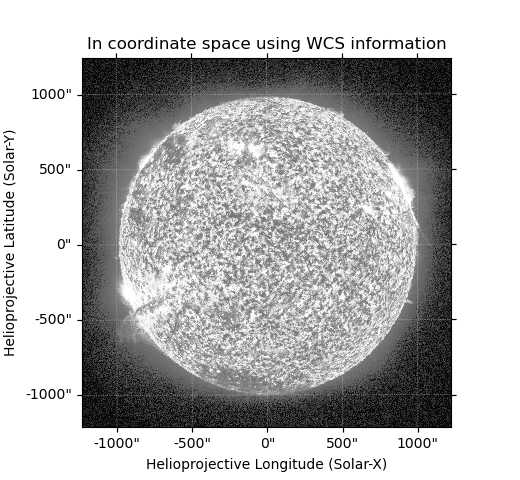
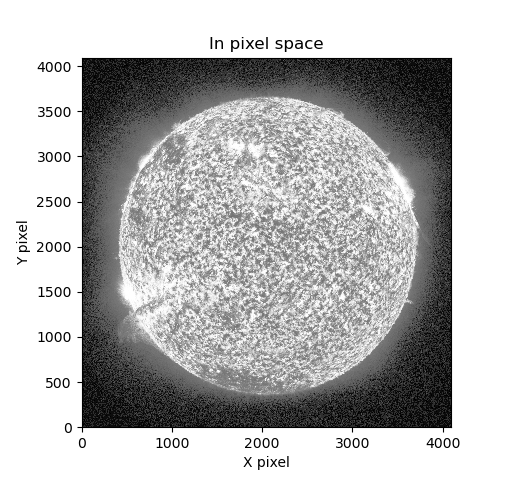
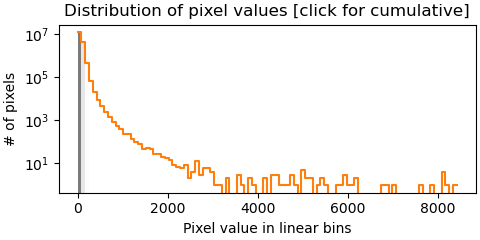
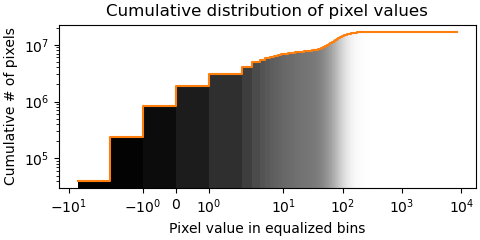

In [77]:
m_aia

In [126]:
m_aia.meta['rsun_obs']

974.634085

In [20]:
m_aia.data

array([[ 0, -1,  0, ...,  0,  1,  0],
       [-1, -1,  1, ...,  2, -2,  1],
       [-1,  1,  3, ...,  0, -1,  2],
       ...,
       [ 1,  0, -2, ..., -2,  0, -1],
       [ 0,  0, -1, ..., -1, -1,  1],
       [ 0,  0,  1, ...,  0,  2,  0]], dtype=int16)

In [34]:
print('Min:', np.min(m_aia.data))
print('Max:', np.max(m_aia.data))
print('Mean:', np.mean(m_aia.data))
print('Stdev:', np.std(m_aia.data))
print('Sum:', np.sum(m_aia.data))

Min: -7
Max: 8428
Mean: 49.72127020359039
Stdev: 57.54598451095046
Sum: 834184490


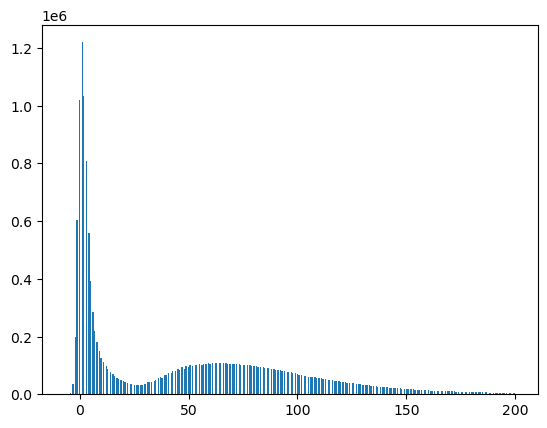

In [61]:
flat_m=m_aia.data.flatten()
fig,ax = plt.subplots();
ax.hist(flat_m,bins='auto',range=(-7,200));

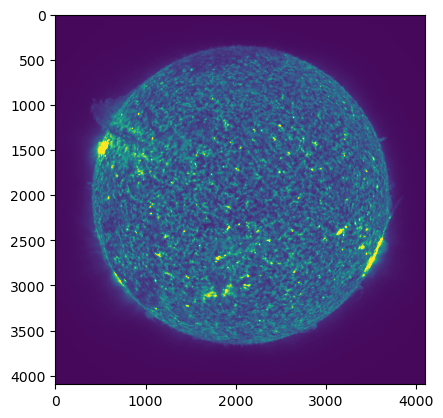

In [37]:
fig,ax = plt.subplots()
ax.imshow(m_aia.data,vmax=300)

### aiapy
https://aiapy.readthedocs.io/en/stable/generated/gallery/prepping_level_1_data.html#sphx-glr-generated-gallery-prepping-level-1-data-py
normalize_exposure(register(update_pointing(m_aia)))

In [78]:
m_normalized=normalize_exposure(register(update_pointing(m_aia)))

In [8]:
test=register(update_pointing(m_aia))

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2011-01-27 22:58:56
Exposure Time,1.0 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.6 0.6] arcsec / pix
Reference Pixel,[2047.5 2047.5] pix

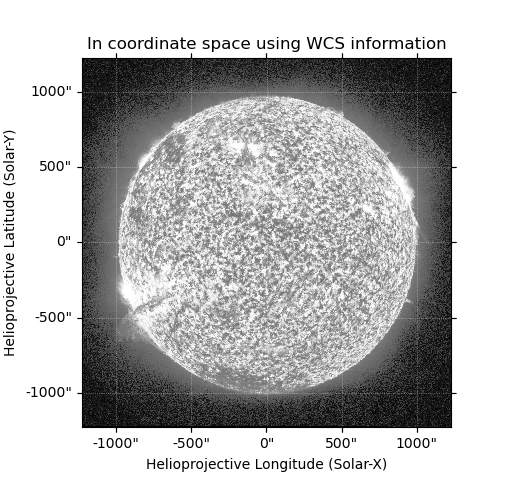
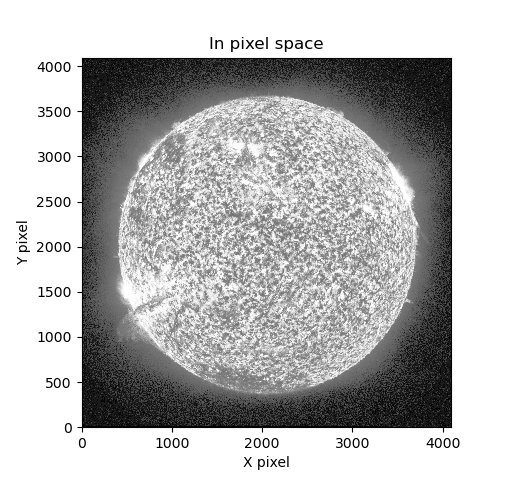
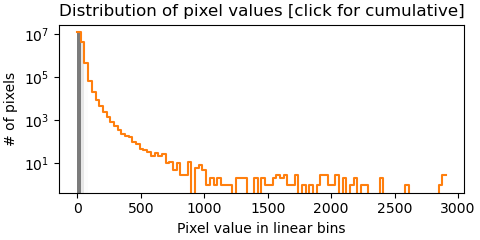
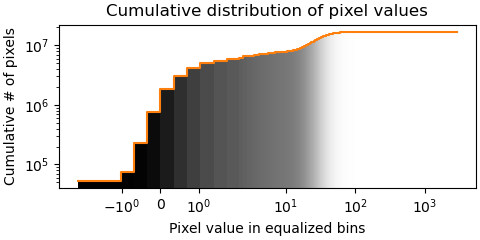

In [79]:
m_normalized

In [85]:
m_normalized.data.shape

(4096, 4096)

In [81]:
m_normalized.meta['rsun_obs']

974.634085

In [86]:
print('Min:', np.min(m_normalized.data))
print('Max:', np.max(m_normalized.data))
print('Mean:', np.mean(m_normalized.data))
print('Stdev:', np.std(m_normalized.data))
print('above 0 :', np.sum(m_normalized.data>0)/4096**2)
print('Sum:', np.sum(m_normalized.data))

Min: -2.411994919649558
Max: 2904.0418832580676
Mean: 17.133664835458095
Stdev: 19.81394420378406
above 0 : 0.8915912508964539
Sum: 287455195.8160849


In [18]:
m_aia.data.sum()/m_normalized.data.sum()

0.9999316073380982

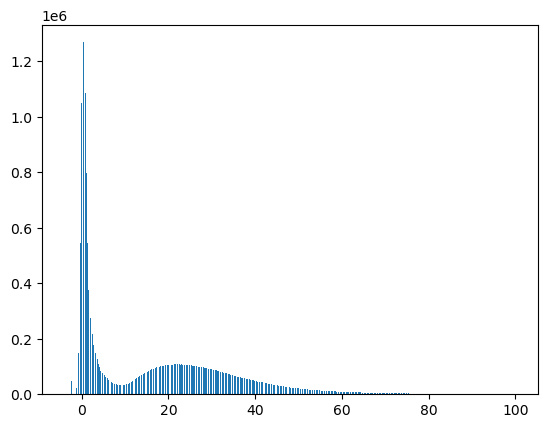

In [58]:
flat_normalized=m_normalized.data.flatten()
fig,ax = plt.subplots()
ax.hist(flat_normalized,bins='auto',range=(-4,100));

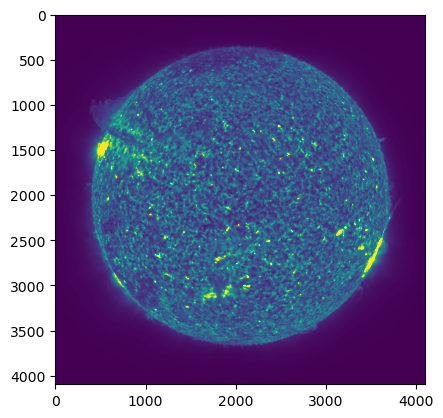

In [45]:
fig,ax = plt.subplots()
ax.imshow(m_normalized.data,vmin=0,vmax=100)

### IDL

In [3]:
sav_filename = "data_IDL/IDL_data.sav"
sav_data = readsav(sav_filename)
image_data_4096 = sav_data['out_data']

In [5]:
image_data_4096.sum()

826561249

# visualization 
## 4096

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import math
from calculating_DN_4096 import wavelength_point_num, wavelength_list
from calculating_DN_4096 import angle_point_num_alpha,offaxis_angle_x_alpha, offaxis_angle_y_alpha
from calculating_DN_4096 import angle_point_num_beta,offaxis_angle_x_beta, offaxis_angle_y_beta

DN=np.load("output_DN/_4096/DN_4096.npz")

# Initialize
# Cruciformscan in alpha direction
offaxis_angle_x_min_alpha=offaxis_angle_x_alpha*180*60/math.pi

# Cruciformscan in beta direction
offaxis_angle_y_min_beta=offaxis_angle_y_beta*180*60/math.pi

# Fit data in DN??.npz
wavelength_shift_alpha = np.zeros(angle_point_num_alpha)
fit_alpha = []   # List of Gaussian1D
for i in range(angle_point_num_alpha):
    g_init = models.Gaussian1D(amplitude=1E9, mean=0.05, stddev=0.0424)
    # initial value for fitting
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, wavelength_list, DN['DN_alpha'][i])
    wavelength_shift_alpha[i] = g.mean.value
    fit_alpha.append(g)

Text(0, 0.5, 'Digital Number per nm (?)')

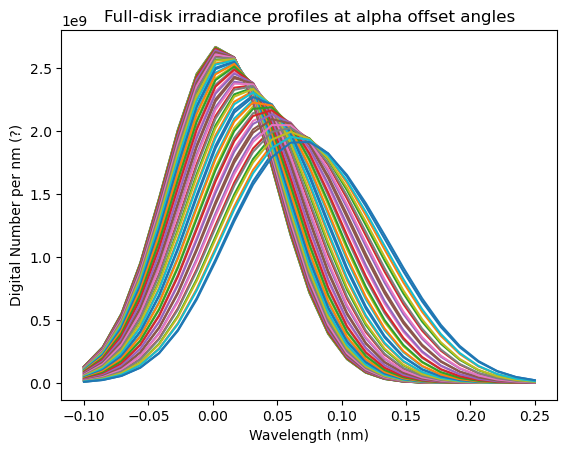

In [9]:
# Profiles during cruciformscan
fig, ax = plt.subplots()
# Profiles during cruciformscan in alpha direction
for i in range(angle_point_num_alpha):
    ax.plot(wavelength_list, DN['DN_alpha'][i], label='linear')
# ax.set_title("He II 谱线轮廓随入射偏角𝜶变化的模拟结果")
ax.set_title("Full-disk irradiance profiles at alpha offset angles")
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("Digital Number per nm (?)")

Text(0.5, 1.0, 'Full-disk irradiance profiles at alpha offset angles')

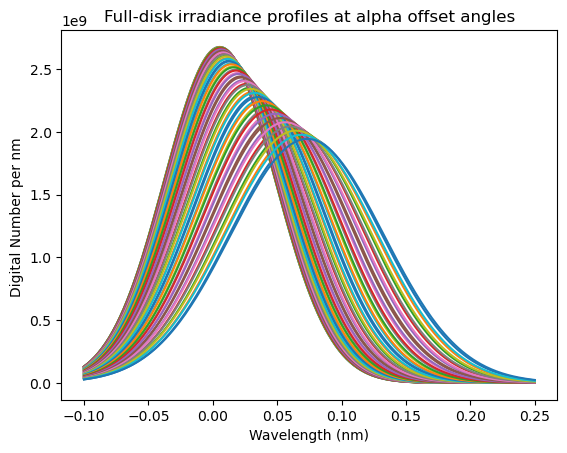

In [10]:
# Fitted profiles during cruciformscan
fig, ax = plt.subplots()
wavelength_densed_list = np.linspace(-0.1, 0.25, 10*wavelength_point_num)
# Profiles during cruciformscan in alpha direction
for i in range(angle_point_num_alpha):
    ax.plot(wavelength_densed_list, fit_alpha[i](
        wavelength_densed_list), label='linear')

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("Digital Number per nm ")
ax.set_title("Full-disk irradiance profiles at alpha offset angles")

Text(0.5, 1.0, 'Unpanned simulation')

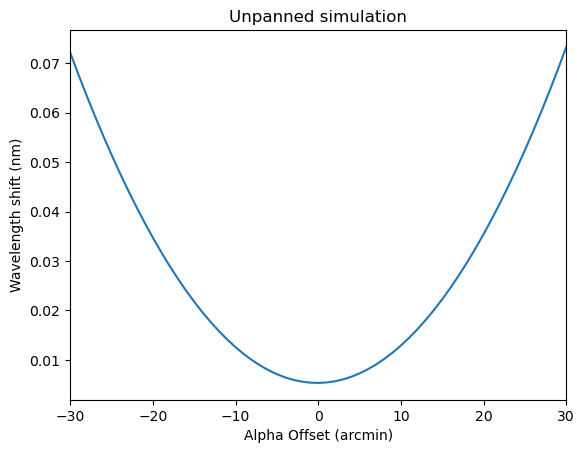

In [11]:
# Central wavelength shift
fig, ax = plt.subplots()
ax.plot(offaxis_angle_x_min_alpha, wavelength_shift_alpha)
ax.set_xlabel("Alpha Offset (arcmin)")
ax.set_ylabel('Wavelength shift (nm)')
ax.set_xlim(-30,30)
ax.set_title("Unpanned simulation")

(-30.0, 30.0)

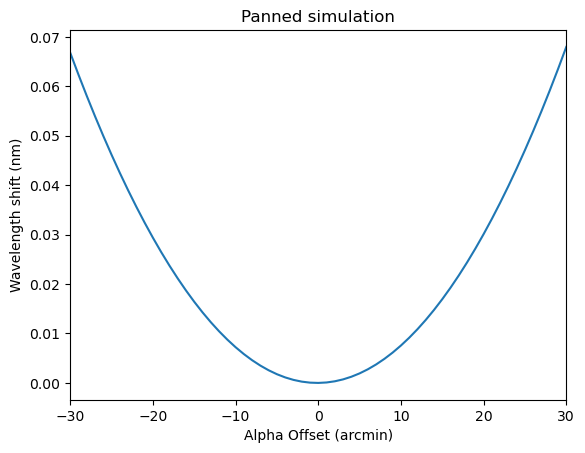

In [12]:
# Panned central wavelength shift
# Y 轴的零点被设定为全日面 He II 谱线在没有任何 SDO 卫星偏转时的中心波长位置，
# 也就是𝛼 = 0且𝛽 = 0的情况
# 我采用直接向下平移

fig, ax = plt.subplots()
ax.plot(offaxis_angle_x_min_alpha, wavelength_shift_alpha -
        wavelength_shift_alpha[int(angle_point_num_alpha/2)]) # 我采用直接向下平移
ax.set_ylabel('Wavelength shift (nm)')
ax.set_xlabel("Alpha Offset (arcmin)")
ax.set_title("Panned simulation")
ax.set_xlim(-30,30)

## 2048

In [6]:
wavelength_point_num = 25
wavelength_list = np.linspace(-0.1, 0.25, wavelength_point_num)
# P43 图3.3 横坐标波长范围  单位nm

# Cruciformscan in alpha direction
# P42 步骤四   采用弧度制
angle_point_num_alpha = 61
DN_alpha = np.zeros((angle_point_num_alpha, wavelength_point_num))
offaxis_angle_x_alpha = np.linspace(-math.pi /
                                    360, math.pi/360, angle_point_num_alpha)
offaxis_angle_y_alpha = np.zeros(angle_point_num_alpha)


# Cruciformscan in beta direction
# P42 步骤四   采用弧度制
angle_point_num_beta = 61
DN_beta = np.zeros((angle_point_num_beta, wavelength_point_num))
offaxis_angle_x_beta = np.zeros(angle_point_num_beta)
offaxis_angle_y_beta = np.linspace(-math.pi /
                                   360, math.pi/360, angle_point_num_beta)

normalized_data = np.load("data/AIA/image_data_4096_normalized.npz")
image_data_4096 = normalized_data["image_data"]
image_data = sunpy.image.resample.resample(
    image_data_4096, dimensions=(2048, 2048))
image_shape_x, image_shape_y = image_data.shape

In [9]:
def wavelength_shift(Tx, Ty, A=886.81, B=0.91002):
    return A * Tx**2 + B * Ty

def my_Gaussian1D(wavelength_list, amplitude, mean, stddev):
    results = np.array([amplitude * np.exp(-(x - mean) ** 2 / (2 * stddev ** 2))
                        for x in wavelength_list])
    return results

wavelength_list, offaxis_angle_x, offaxis_angle_y = (
    np.linspace(-0.1, 0.2, 10), 0, 0)
total_irradiance = 0
stddev = np.zeros((image_shape_x, image_shape_y))+0.1 * \
    gaussian_fwhm_to_sigma  # unit: nm

# Create NumPy arrays for pixel indices and image data
pixel_x = np.arange(image_shape_x)
pixel_y = np.arange(image_shape_y)
Px, Py = np.meshgrid(pixel_x, pixel_y, indexing='ij')

# Compute Tx and Ty for all pixels in parallel
Tx, Ty = my_pixel_to_world(2 * Px, 2 * Py)  # 使用2048的照片，所以乘以2
Tx += offaxis_angle_x  # P42 步骤三 四 将卫星整体偏转

Ty += offaxis_angle_y  # P42 步骤三 四 将卫星整体偏转

# Compute amplitude, mean, and stddev for all pixels in parallel
amplitude = image_data / (np.sqrt(2 * pi) * stddev)
mean = wavelength_shift(Tx, Ty)
coeff = np.array([amplitude, mean, stddev])

# Compute total_irradiance using vectorized NumPy operations
b = my_Gaussian1D(wavelength_list, *coeff)
s = np.sum(b, axis=(1, 2))
s.shape

(10,)

In [17]:
a=Tx**2+Ty**2-(974.634085*math.pi/(3600*180))**2
a.shape

(2048, 2048)

In [11]:
np.sum(a<0)/2048**2

0.4938793182373047

In [12]:
pi*974.634085**2/(4096*0.6)**2

0.4940952365598167

In [13]:
974.634085/0.6

1624.3901416666668

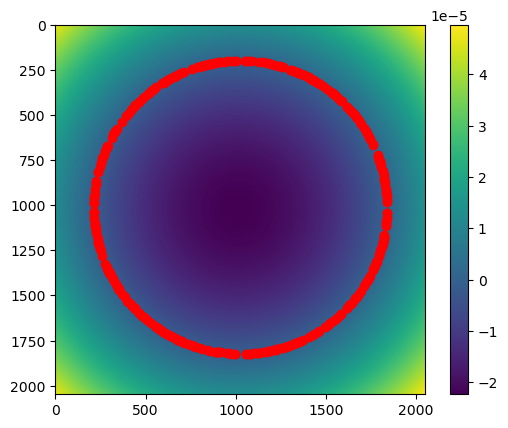

In [14]:
fig,ax = plt.subplots()
sc=ax.imshow(a)
fig.colorbar(sc)
ax.scatter(np.array(np.where(abs(a)<2e-9))[0],
          np.array(np.where(abs(a)<2e-9))[1],c='r')

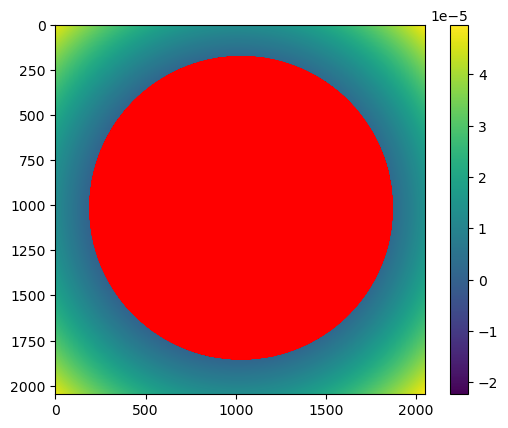

In [15]:
fig,ax = plt.subplots()
sc=ax.imshow(a)
fig.colorbar(sc)
ax.scatter( np.array(np.where(a<0))[0],
          np.array(np.where(a<0))[1],c='r')

In [105]:
np.array(np.where(abs(a)<1e-7))

array([[ 213,  213,  213, ..., 1840, 1840, 1840],
       [ 995,  996,  997, ..., 1036, 1037, 1038]], dtype=int64)

## draft

In [11]:

c=np.array([5,6])

In [12]:
a*3**b

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [18]:
a=np.array([1,2,9])
b=np.array([3,4])
b = np.reshape(b, (1, -1))
def fun(a,b):
    return a*2**b
fun(a,b)

ValueError: operands could not be broadcast together with shapes (3,) (1,2) 

In [20]:
b = np.reshape(b, (1, -1))
b.shape

(1, 2)

In [63]:
import numpy as np
from pixel_to_world.my_pixel_to_world import my_pixel_to_world

def wavelength_shift(Tx, Ty, A=886.81, B=0.91002):
    return A * Tx**2 + B * Ty

def my_Gaussian1D(x, amplitude, mean, stddev):
    return amplitude*math.e**(-(x-mean)**2/(2*stddev**2))

def calculating_DN(wavelength, offaxis_angle_x, offaxis_angle_y):
    total_irradiance = 0
    stddev = 0.1 * gaussian_fwhm_to_sigma  # unit: nm

    # Create NumPy arrays for pixel indices and image data
    pixel_x = np.arange(image_shape_x)
    pixel_y = np.arange(image_shape_y)
    Px, Py = np.meshgrid(pixel_x, pixel_y, indexing='ij')

    # Compute Tx and Ty for all pixels in parallel
    Tx,Ty = my_pixel_to_world(2 * Px, 2 * Py)  # 使用2048的照片，所以乘以2
    Tx += offaxis_angle_x  # P42 步骤三 四 将卫星整体偏转
    
    Ty += offaxis_angle_y  # P42 步骤三 四 将卫星整体偏转

    # Compute amplitude, mean, and stddev for all pixels in parallel
    amplitude = image_data / (np.sqrt(2 * np.pi) * stddev)
    mean = wavelength_shift(Tx, Ty)
    coeff = np.array([amplitude, mean, stddev])

    # Compute total_irradiance using vectorized NumPy operations
    total_irradiance = np.sum(my_Gaussian1D(wavelength, *coeff), axis=(0, 1))  # P42 步骤二

    return total_irradiance

In [70]:
image_shape_x=2
image_shape_y=2
image_data=np.array([[10000,100000],[20,30]])
calculating_DN([0,1],0,0)

C:\Users\asus-pc\AppData\Local\Temp\ipykernel_19364\2187564447.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coeff = np.array([amplitude, mean, stddev])


77535.54046348354

In [43]:
Px, Py = np.meshgrid([1,2],[3,4], indexing='ij')
Px

array([[1, 1],
       [2, 2]])

In [44]:
Py

array([[3, 4],
       [3, 4]])

In [45]:
Px, Py = np.meshgrid([1,2],[3,4])
Px

array([[1, 2],
       [1, 2]])

In [46]:
Py

array([[3, 3],
       [4, 4]])

In [48]:
image_shape_x=20
image_shape_y=20
pixel_x = np.arange(image_shape_x)
pixel_y = np.arange(image_shape_y)
Px, Py = np.meshgrid(pixel_x, pixel_y, indexing='ij')
Px

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [50]:
m_aia.data

array([[ 0, -1,  0, ...,  0,  1,  0],
       [-1, -1,  1, ...,  2, -2,  1],
       [-1,  1,  3, ...,  0, -1,  2],
       ...,
       [ 1,  0, -2, ..., -2,  0, -1],
       [ 0,  0, -1, ..., -1, -1,  1],
       [ 0,  0,  1, ...,  0,  2,  0]], dtype=int16)

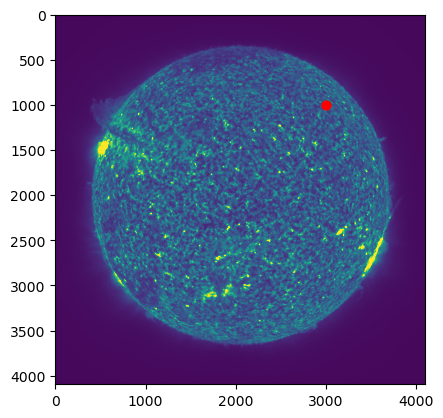

In [56]:
fig,ax = plt.subplots()
ax.imshow(m_aia.data,vmax=300)
ax.scatter(3000,1000,c='red',s=40)

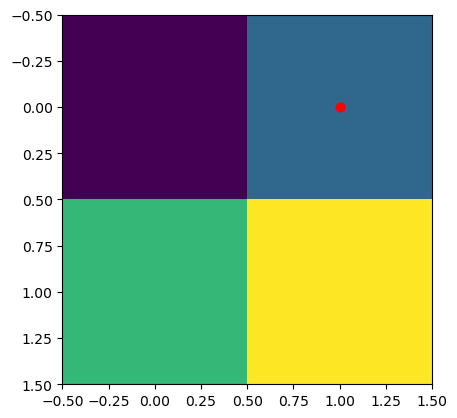

In [71]:
fig,ax = plt.subplots()
test_array=np.array([[1,2],[3,4]])
ax.imshow(test_array)
ax.scatter(1,0,c='red',s=40)

In [67]:
np.sum(test_array,axis=(0,1))

10

In [73]:
a=np.array([[1,2],[3,4]])
b=np.array([[1,2],[30,4]])
c=b>20
c

array([[False, False],
       [ True, False]])

In [75]:
a*c

array([[0, 0],
       [3, 0]])

In [31]:
disk = Tx**2+Ty**2-(974.634085*math.pi/(3600*180)
                    )**2 > 0  # according to 'rsun_obs'
image_data_disk = image_data*disk

In [32]:
image_data.shape

(2048, 2048)

In [33]:
image_data_disk.shape

(2048, 2048)

In [25]:
a=np.zeros((20,30))
def b():
    global a
    a=a+1
    print(a)
b()

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

3
